<a href="https://colab.research.google.com/github/Hubajube/colab/blob/main/Test_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section Links

*   [Mount GDrive](#gdrive)
*   [Image library installs](#imagelib1)
*   [Image library includes](#imagelib2)
*   [Applying text to images](#applytext)









In [1]:
#@markdown #**Mount GDrive** 
#@markdown #<a name="gdrive"></a>
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

working_dir = '/content/gdrive/MyDrive/vqgan'

Mounted at /content/gdrive


In [3]:
#@markdown #**Image library installs** 
#@markdown #<a name="imagelib1"></a>

print("Installing libraries...")
#!pip install stegano                                      &> /dev/null
#!apt install exempi                                       &> /dev/null
#!pip install python-xmp-toolkit                           &> /dev/null
#!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null




Installing libraries...


In [4]:
#@markdown #**Image libraries**
#@markdown #<a name="imagelib2"></a>


import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
#import matplotlib.pyplot as plt

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def apply_basic_transformation(img, center_offset, angle, zoom, translation):
  pivot_x = int(np.floor(img.shape[0]*(.5+center_offset[0]/2)))
  pivot_y = int(np.floor(img.shape[1]*(.5+center_offset[1]/2)))
  center = (pivot_x, pivot_y)

  trans_mat = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
  rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

  trans_mat = np.vstack([trans_mat, [0,0,1]])
  rot_mat = np.vstack([rot_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img = cv2.warpPerspective(
          img,
          transformation_matrix,
          (img.shape[1], img.shape[0]),
          borderMode=cv2.BORDER_WRAP
        )

  return img

In [ ]:
#@markdown #**Tilt test**
#@markdown #<a name="tilttest"></a>


img_0 = read_image_workaround('/content/gdrive/MyDrive/vqgan/tests/4000.png')

top_pinch = 50
top_dip = 50
bottom_pinch = -50
bottom_dip = 0


input_pts = np.float32([[0, 0], [400, 0], [400, 400], [0, 400]])
#output_pts = np.float32([[0, 100], [400, 100], [1000, 400],[-600, 400]])

output_pts = np.float32([
                         [top_pinch, top_dip], 
                         [400-top_pinch, top_dip], 
                         [400-bottom_pinch, 400-bottom_dip], 
                         [bottom_pinch, 400-bottom_dip]])

print(output_pts)

transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
M = cv2.getPerspectiveTransform(input_pts,output_pts)
img_1 = cv2.warpPerspective(img_0,M,(400, 400),flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_WRAP)

out = cv2.hconcat([img_0, img_1])
cv2_imshow(out)


In [ ]:
#@title HTilt test
#@markdown #<a name="htilttest"></a>


img_0 = read_image_workaround('/content/gdrive/MyDrive/vqgan/tests/4000.png')

left_pinch = 80
left_dip = 80
right_pinch = -80
right_dip = 0


input_pts = np.float32([[0, 0], [400, 0], [400, 400], [0, 400]])



output_pts = np.float32([
                         [left_dip, left_pinch], 
                         [400-right_dip, right_pinch], 
                         [400-right_dip, 400-right_pinch], 
                         [left_dip, 400-left_pinch]])

print(output_pts)


transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
M = cv2.getPerspectiveTransform(input_pts,output_pts)
img_1 = cv2.warpPerspective(img_0,M,(400, 400),flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_WRAP)

out = cv2.hconcat([img_0, img_1])
cv2_imshow(out)

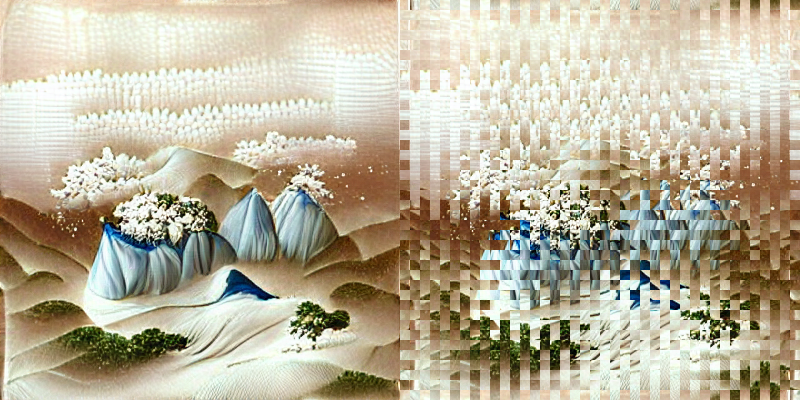

In [28]:
#@markdown #**Window Shades Test**
#@markdown #<a name="shadestest"></a>


def Apply_WindowShades(img, stripecount, phase, translation):
  stripeheight=400/stripecount

  img_mask = np.zeros((400,400,3), np.uint8)  

  for stripe in range(0, math.ceil(stripecount/2)):
    top=round(stripe*stripeheight*2 + phase*stripeheight)
    bottom=round(top+stripeheight)
    img_mask[top:bottom,:] = (255,255,255)

  trans_mat = np.float32(
      [[1, 0, translation],
      [0, 1, 0]]
  )
  rot_mat = cv2.getRotationMatrix2D( (0,0), 0, 1 )
  trans_mat = np.vstack([trans_mat, [0,0,1]])
  rot_mat = np.vstack([rot_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img_1 = cv2.warpPerspective(
      img,
      transformation_matrix,
      (img.shape[1], img.shape[0]),
      borderMode=cv2.BORDER_WRAP
  )

  trans_mat = np.float32(
      [[1, 0, -translation],
      [0, 1, 0]]
  )
  trans_mat = np.vstack([trans_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img_2 = cv2.warpPerspective(
      img,
      transformation_matrix,
      (img.shape[1], img.shape[0]),
      borderMode=cv2.BORDER_WRAP
  )

  return cv2.bitwise_or(
        cv2.bitwise_and(img_1, img_mask), 
        cv2.bitwise_and(img_2, np.invert(img_mask))
  )

def Apply_WindowShadesY(img, stripecount, phase, translation):
  stripeheight=400/stripecount

  img_mask = np.zeros((400,400,3), np.uint8)  

  for stripe in range(0, math.ceil(stripecount/2)):
    top=round(stripe*stripeheight*2 + phase*stripeheight)
    bottom=round(top+stripeheight)
    img_mask[:,top:bottom] = (255,255,255)

  trans_mat = np.float32(
      [[1, 0, 0],
      [0, 1, translation]]
  )
  rot_mat = cv2.getRotationMatrix2D( (0,0), 0, 1 )
  trans_mat = np.vstack([trans_mat, [0,0,1]])
  rot_mat = np.vstack([rot_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img_1 = cv2.warpPerspective(
      img,
      transformation_matrix,
      (img.shape[1], img.shape[0]),
      borderMode=cv2.BORDER_WRAP
  )

  trans_mat = np.float32(
      [[1, 0, 0],
      [0, 1, -translation]]
  )
  trans_mat = np.vstack([trans_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img_2 = cv2.warpPerspective(
      img,
      transformation_matrix,
      (img.shape[1], img.shape[0]),
      borderMode=cv2.BORDER_WRAP
  )

  return cv2.bitwise_or(
        cv2.bitwise_and(img_1, img_mask), 
        cv2.bitwise_and(img_2, np.invert(img_mask))
  )

img_0 = read_image_workaround('/content/gdrive/MyDrive/vqgan/tests/4000.png')
img_5 = Apply_WindowShadesY(img_0, 40, 0, 10)
img_5 = Apply_WindowShades(img_5, 40, 0, 10)



out = cv2.hconcat([img_0, img_5])
cv2_imshow(out)

In [ ]:
#@markdown #**Pinch Test**
#@markdown #<a name="pinchtest"></a>

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def apply_basic_transformation(img, center_offset, angle, zoom, translation):
  pivot_x = int(np.floor(img.shape[0]*(.5+center_offset[0]/2)))
  pivot_y = int(np.floor(img.shape[1]*(.5+center_offset[1]/2)))
  center = (pivot_x, pivot_y)

  trans_mat = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
  rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

  trans_mat = np.vstack([trans_mat, [0,0,1]])
  rot_mat = np.vstack([rot_mat, [0,0,1]])
  transformation_matrix = np.matmul(rot_mat, trans_mat)

  img = cv2.warpPerspective(
          img,
          transformation_matrix,
          (img.shape[1], img.shape[0]),
          borderMode=cv2.BORDER_WRAP
        )

  return img

angle = -10

img_0 = read_image_workaround('/content/gdrive/MyDrive/vqgan/tests/4000.png')

img_mask = np.zeros((400,400,3), np.uint8)
img_mask[:,201:400] = (255,255,255)

img_1 = apply_basic_transformation(img_0, (0,0), angle, 1, (0,0))
img_2 = apply_basic_transformation(img_0, (0,0), -angle, 1, (0,0))

img_final = cv2.bitwise_or( 
                cv2.bitwise_and(img_1, img_mask),
                cv2.bitwise_and(img_2, np.invert(img_mask))
            )

out = cv2.hconcat([img_0, img_final])
cv2_imshow(out)

283 0.17667844522968199


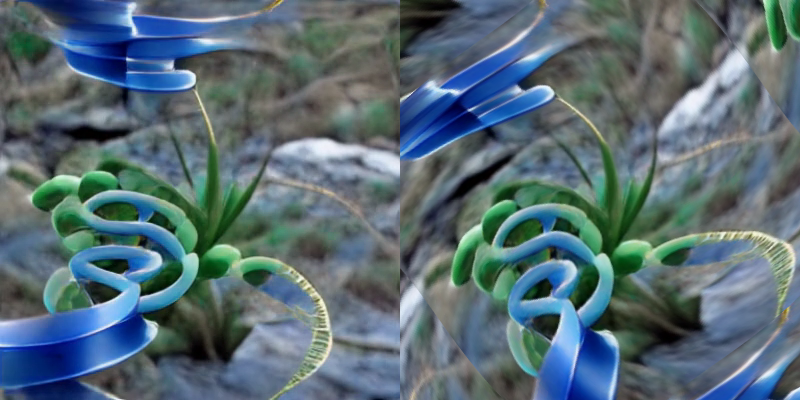

In [ ]:
#@markdown #**Spiral Test**
#@markdown #<a name="spiraltest"></a>

import math


angle = 50
ring_size = 1
ring_count = math.ceil(283/ring_size)
overlap = 0
reverse = False
method = 2
print(ring_count, angle/ring_count)

img_0 = read_image_workaround('/content/gdrive/MyDrive/vqgan/steps/15000.png')

#img_mask_list = []
#img_list = []

img_final = np.zeros((400,400,3), np.uint8)

for i in range(0,ring_count+1):
  img_mask = np.zeros((400,400,3), np.uint8)
  if method==1:
    img_mask = cv2.circle(img_mask, (200,200), i*ring_size, (255,255,255), ring_size+overlap)
  else:
    img_mask = cv2.circle(img_mask, (200,200), i*ring_size, (255,255,255), -1)
    if i>0:
      img_mask = cv2.circle(img_mask, (200,200), (i-1)*ring_size, (0,0,0), -1)
  #img_mask_list.append(img_mask)

  if reverse:
    img = apply_basic_transformation(img_0, (0,0), (ring_count-i)*angle/ring_count, 1, (0,0))
  else:
    img = apply_basic_transformation(img_0, (0,0), (i-1)*angle/ring_count, 1, (0,0))
   
  img_combine = cv2.bitwise_and(img, img_mask)

  img_final = cv2.bitwise_or(img_final, img_combine)

  #out = cv2.hconcat([img_combine, img_mask, img_final])
  #cv2_imshow(out)

out = cv2.hconcat([img_0, img_final])
cv2_imshow(out)
